# Improving Graph

Table of contents

1. [Reading Data](#sec1)
2. [Edges, Nodes, Weights](#sec2)
3. [Baseline Graph](#sec3)
4. [Graph Summary](#sec3a)
5. [Filtered Graph](#sec4)
6. [Community Detection](#sec5)

We will improve our graph by:
1. Defining clear edge weights (and later node size)
2. Using better visualizations using Plotly which is interactive

In [1]:
import networkx as nx
import json

import math
import statistics
from sklearn import preprocessing # to normalize

from collections import Counter, defaultdict, OrderedDict

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

import os

<a id="sec1"> </a>
## Reading Data

In [2]:
pd = os.path.split(os.getcwd())[0]
data_fp = os.path.join(pd,"data/newssources-subreddits")

In [3]:
# ns_subreddit
with open(os.path.join(data_fp,"ns_subreddit_2021-01.json")) as infile1:
    ns_subreddit_01 = json.load(infile1)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-02.json")) as infile2:
    ns_subreddit_02 = json.load(infile2)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-03.json")) as infile3:
    ns_subreddit_03 = json.load(infile3)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-04.json")) as infile4:
    ns_subreddit_04 = json.load(infile4)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-05.json")) as infile5:
    ns_subreddit_05 = json.load(infile5)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-06.json")) as infile6:
    ns_subreddit_06 = json.load(infile6)
   
# subreddit_ns
with open(os.path.join(data_fp,"subreddit_ns_2021-01.json")) as infile1a:
    subreddit_ns_01 = json.load(infile1a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-02.json")) as infile2a:
    subreddit_ns_02 = json.load(infile2a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-03.json")) as infile3a:
    subreddit_ns_03 = json.load(infile3a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-04.json")) as infile4a:
    subreddit_ns_04 = json.load(infile4a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-05.json")) as infile5a:
    subreddit_ns_05 = json.load(infile5a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-06.json")) as infile6a:
    subreddit_ns_06 = json.load(infile6a)

Let's define our `news_sources` and `subreddits`.

In [4]:
news_sources = list(set(ns_subreddit_01.keys()) & 
                    set(ns_subreddit_02.keys()) & 
                    set(ns_subreddit_03.keys()) 
                    & set(ns_subreddit_04.keys()) & 
                    set(ns_subreddit_05.keys()) & 
                    set(ns_subreddit_06.keys())
                   )
len(news_sources)

1403

In [5]:
subreddits = list(set(subreddit_ns_01.keys()) &
                  set(subreddit_ns_02.keys()) &
                 set(subreddit_ns_03.keys()) 
                  & set(subreddit_ns_04.keys()) &
                 set(subreddit_ns_05.keys()) &
                 set(subreddit_ns_06.keys())
                 )
len(subreddits)

9195

Let's only use subreddits with the most subscribers

In [6]:
# Let's only use the subreddits that have lots of subscribers
with open ("D:\\Wellesley\\F21\\thesis\\data\\subreddits\\subreddit_subscribers.json", "r", encoding = "utf-8") as infile:
    subreddit_subscribers = json.load(infile)

In [7]:
subreddits_w_subc = [subreddits[k] for k in range(len(subreddits)) if subreddits[k] in subreddit_subscribers]
len(subreddits_w_subc)

8297

Out of our 9.1k subreddits, we only have subscribers data for 8.2k of them. Let's drop the descriptions with `None` values.

In [8]:
subreddits_w_subc = [s for s in subreddits_w_subc if subreddit_subscribers[s] is not None]
len(subreddits_w_subc)

8294

In [9]:
TOTAL_SUBSCRIBERS = sum([subreddit_subscribers[s] for s in subreddits_w_subc])
TOTAL_SUBSCRIBERS

1784259273

In [10]:
srs_all = sorted(subreddits_w_subc, key= lambda x: subreddit_subscribers[x], reverse= True)

In [11]:
# example number of subsribers
[(s,subreddit_subscribers[s]) for s in srs_all[:10] if subreddit_subscribers[s] > 0]

[('funny', 31060166),
 ('gaming', 26628444),
 ('aww', 25197817),
 ('pics', 24911449),
 ('science', 24268001),
 ('worldnews', 24253881),
 ('Music', 24041486),
 ('videos', 23114010),
 ('movies', 23087255),
 ('todayilearned', 23030716)]

Text(0.5, 1.0, 'All Subreddit Subscribers')

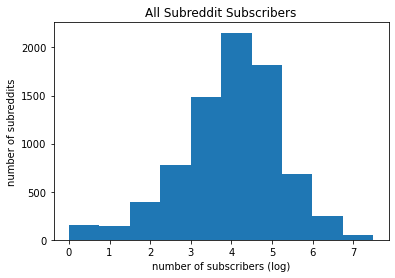

In [12]:
# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])

plt.hist([math.log(subreddit_subscribers[s],10) for s in srs_all if subreddit_subscribers[s] > 0])
plt.xlabel("number of subscribers (log)")
plt.ylabel("number of subreddits")
plt.title("All Subreddit Subscribers")

# could log scale for both x and y

In [13]:
len([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])

7898

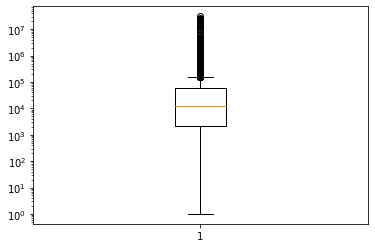

In [14]:
plt.boxplot([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])
plt.yscale("log")

Text(0.5, 1.0, 'Top 1k Subreddit Subscribers')

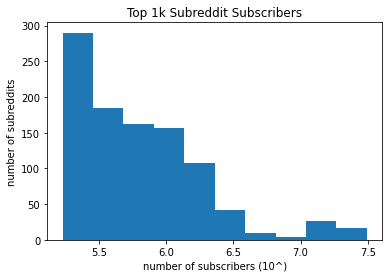

In [15]:
# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])

plt.close()
# plt.yscale("log")
plt.hist([math.log(subreddit_subscribers[s],10) for s in srs_all[:1000] if subreddit_subscribers[s] > 0])
plt.xlabel("number of subscribers (10^)")
plt.ylabel("number of subreddits")
plt.title("Top 1k Subreddit Subscribers")

# could log scale for both x and y

In [16]:
# srs_1000 = srs_all[:1000]
srs_1000 = srs_all[:200] # using 1000 subreddits yields in very condensed graph.

In [17]:
len(srs_all)

8294

<a id="sec2"> </a>
    
## Edges, Nodes, and Weights

As edge weight, we need to take into account the contribution of each of the subreddits in which the pair of news sources co-occur. We use the formula to weigh one subreddit

```(min/max) * ((min+max)/2)```

where `min` is the smaller out of the numbers of occurences of the two news sources and `max` is the bigger one.

Then for the actual weight of the edge, we take weighted average of all the subreddits contributions, based on the number of subscribers of those subreddits.

For example, if a pair of news sources co-occur in the following subreddits with the associated subscribers:

```
subreddit    |    # subreddit subscribers
-------------------------------------------
 fun         |           1000
 news        |           500
 nft         |           25
```

Then we would weigh the edge between the two as follows:

```
contribution(fun)*1000 + contribution(news)*500 + contribution(nft)*25
------------------------------------------------------------------------
                     1000+500+25
```

[or should I use total subscribers in the whole dataset as the denominator?]



To do: actually edit the code



In [18]:
subreddit_files = [subreddit_ns_01, subreddit_ns_02, subreddit_ns_03
                   , subreddit_ns_04, subreddit_ns_05, subreddit_ns_06
                  ]

First we calculate the strength of relationship between two nodes, based on each of the number of their occurences in each subreddit they co-occur in.

In [19]:
# co_occurences = defaultdict(int)
per_subreddits = defaultdict(list) # list of tuple to include the actual subreddit (for weighted average)
node_sizes = defaultdict(int)

# to decide weight algorithm
cc = defaultdict(tuple) # co-occurences

for subreddit_file in subreddit_files:
    for s in subreddit_file:
        # we will only process for this subreddit if it is one of the 1k subreddits with the most subscribers
        if s not in srs_1000:
            continue
        # each s contains news sources and how many times they appear
        news_sources1 = list(subreddit_file[s].keys())
        # make pairings
        i = 0
        while i < len(news_sources1)-1:
            # record node details for this particular news source
            node_sizes[news_sources1[i]] += 1
            j = i + 1
            while j <= len(news_sources1)-1:
                ns_pair = sorted([news_sources1[i], news_sources1[j]])
                # cast to be tuple after sorting in alphabetical pair
                ns_pair = tuple(ns_pair)
                n1, n2 = ns_pair
                # the pairing co_occur in this subreddit
                # co_occurences[ns_pair] += 1 # old
                # let's find the min and max occurences
                s1 = subreddit_file[s][n1]
                s2 = subreddit_file[s][n2]
                maxx = max(s1,s2)
                minn = min(s1,s2)
                cc[(n1,n2)] = (minn, maxx)
                # then calculate the weight for this one 
                weight = (minn/maxx)*((minn+maxx)/2) 
                per_subreddits[ns_pair].append((weight,s))
                j += 1
            i += 1
        # increment for the last news source
        node_sizes[news_sources1[-1]] += 1

In [21]:
data = dict((':'.join(k), v) for k,v in cc.items())

In [22]:
len(data)

773570

In [23]:
with open("co_occurences_values.json", "w", encoding="utf-8") as ccfile:
    json.dump(data, ccfile)

In [19]:
per_subreddits[('nytimes.com', 'wsj.com')]

[(1.1666666666666665, 'nba'),
 (37.41635687732342, 'Coronavirus'),
 (169.8684593023256, 'politics'),
 (98.71345029239765, 'news'),
 (0.5625, 'science'),
 (15.6, 'technology'),
 (1.8214285714285714, 'movies'),
 (34.45054945054945, 'worldnews'),
 (0.5208333333333333, 'atheism'),
 (0.5833333333333333, 'Music'),
 (8.065217391304348, 'nottheonion'),
 (2.6666666666666665, 'nfl'),
 (0.5714285714285714, 'PublicFreakout'),
 (3.835616438356164, 'todayilearned'),
 (3.5454545454545454, 'UpliftingNews'),
 (3.392857142857143, 'Futurology'),
 (0.515625, 'europe'),
 (0.5454545454545454, 'space'),
 (4.5, 'television'),
 (2.0625, 'Bitcoin'),
 (1.5, 'JusticeServed'),
 (2.142857142857143, 'sports'),
 (0.75, 'gadgets'),
 (1.75, 'books'),
 (0.6666666666666666, 'MadeMeSmile'),
 (1.0, 'Games'),
 (2.4, 'cars'),
 (1.0, 'malefashionadvice'),
 (1.0952380952380951, 'nba'),
 (69.47102212855637, 'politics'),
 (52.37375745526839, 'news'),
 (37.287449392712546, 'Coronavirus'),
 (1.2000000000000002, 'entertainment'),
 

Let's only consider pairings that co-occur at least 10 times.

In [20]:
per_subreddits_10 = {p: per_subreddits[p] for p in per_subreddits if len(per_subreddits[p]) >= 10}

In [21]:
len(per_subreddits)

680078

In [22]:
len(per_subreddits_10)

83694

Then, we take an average of the strengths and set the edge weight to be this. I could also use the maximum value. Should I?

Instead, I think I should take weighted average as I talked about previously, based on # subscribers.

In [23]:
weights = defaultdict(int)

for pair in per_subreddits_10:
    # weights[pair] = statistics.mean(per_subreddits[pair])
    weights[pair] = sum([contr*subreddit_subscribers[subr]/TOTAL_SUBSCRIBERS for contr, subr in per_subreddits[pair]])

In [24]:
weights[('nytimes.com', 'wsj.com')]

7.1679703460488415

In [25]:
weights

defaultdict(int,
            {('sun-sentinel.com', 'yahoo.com'): 0.33159956444149397,
             ('bleacherreport.com', 'yahoo.com'): 0.4473565478902853,
             ('blogspot.com', 'yahoo.com'): 27.83418437519308,
             ('espn.com', 'yahoo.com'): 2.571232080936143,
             ('smh.com.au', 'yahoo.com'): 1.377404894387604,
             ('radio.com', 'yahoo.com'): 0.5149772199475199,
             ('nytimes.com', 'yahoo.com'): 32.61803398462566,
             ('variety.com', 'yahoo.com'): 1.7099968714998794,
             ('latimes.com', 'yahoo.com'): 5.190470944924266,
             ('usatoday.com', 'yahoo.com'): 11.49989615472818,
             ('nypost.com', 'yahoo.com'): 12.231575530162443,
             ('fivethirtyeight.com', 'yahoo.com'): 0.5206927887462048,
             ('complex.com', 'yahoo.com'): 0.626649862981714,
             ('usnews.com', 'yahoo.com'): 3.8015968155295465,
             ('wikipedia.org', 'yahoo.com'): 2.8564737594360334,
             ('cbslocal.com'

In [29]:
len(weights)

83694

How many edges have weight of more than 10?

In [27]:
print(len([e for e in weights if weights[e] > 10]))

284


(array([40., 15., 11.,  7.,  4.,  3.,  1.,  0.,  0.,  1.]),
 array([20.26348334, 26.61553951, 32.96759568, 39.31965186, 45.67170803,
        52.02376421, 58.37582038, 64.72787655, 71.07993273, 77.4319889 ,
        83.78404508]),
 <BarContainer object of 10 artists>)

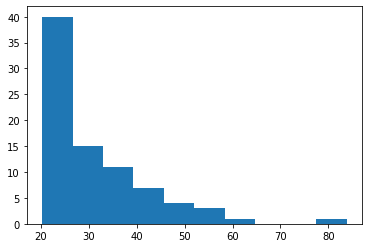

In [29]:
plt.hist([weights[e] for e in weights if weights[e]>20])

In [30]:
print([(e,weights[e]) for e in weights if weights[e]>70])

[(('blogspot.com', 'reuters.com'), 83.78404507633026)]


Maybe I could treat these 284 as outliers in my graph visualization, but leave it as is for community generation, graph description etc.

Now (I think) we are ready to build our graph!

## Preparing for Building a Graph

In [31]:
G = nx.Graph()
for e, w in list(weights.items()):
    u, v = e
    G.add_edge(u, v, weight=w)

In [32]:
# sanity check
'nytimes.com' in G.nodes()

True

In [33]:
len(G.nodes())

629

In [34]:
len(G.edges())

83694

Let's first visualize the node sizes and edge weights.

Text(0.5, 1.0, 'Node Sizes')

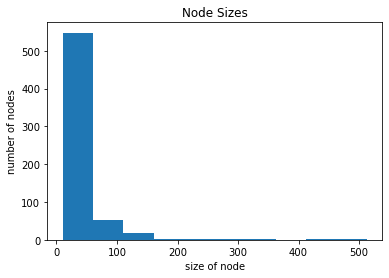

In [35]:
# Node Size
plt.close()
plt.hist([node_sizes[n] for n in G.nodes()])
# plt.yscale("log")
plt.ylabel("number of nodes")
plt.xlabel("size of node")
plt.title("Node Sizes")

Text(0.5, 1.0, 'Edge Weights')

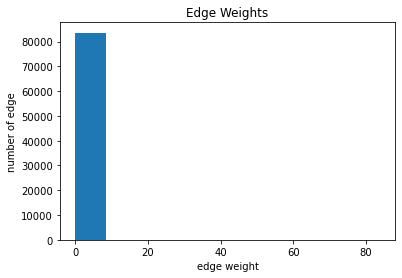

In [36]:
# Edge Weight
plt.close()
# plt.hist([weights[n] for n in G.edges()])
plt.hist([weights[n] for n in G.edges()])
# plt.yscale("log")
plt.ylabel("number of edge")
plt.xlabel("edge weight")
plt.title("Edge Weights")

In [37]:
len(G.edges())

83694

<a id="sec3"> <a/>
## Building baseline graph

In [38]:
# norm_weights = normalize(freeze_weights)[0].tolist()

min_max_scaler = preprocessing.MinMaxScaler()
baseline_norm_weights = min_max_scaler.fit_transform(np.array([[weights[n] for n in G.edges()]]).T).T[0]

In [39]:
len(G.edges()) == len(baseline_norm_weights)

True

In [40]:
edge_normweights = dict()
edges = list(G.edges())
for ii in range(len(edges)):
    edge_normweights[edges[ii]] = baseline_norm_weights[ii]

In [41]:
len(edge_normweights) == len(G.edges())

True

In [41]:
dir(nx)

['AmbiguousSolution',
 'DiGraph',
 'ExceededMaxIterations',
 'Graph',
 'GraphMLReader',
 'GraphMLWriter',
 'HasACycle',
 'LCF_graph',
 'LFR_benchmark_graph',
 'MultiDiGraph',
 'MultiGraph',
 'NetworkXAlgorithmError',
 'NetworkXError',
 'NetworkXException',
 'NetworkXNoCycle',
 'NetworkXNoPath',
 'NetworkXNotImplemented',
 'NetworkXPointlessConcept',
 'NetworkXTreewidthBoundExceeded',
 'NetworkXUnbounded',
 'NetworkXUnfeasible',
 'NodeNotFound',
 'NotATree',
 'OrderedDiGraph',
 'OrderedGraph',
 'OrderedMultiDiGraph',
 'OrderedMultiGraph',
 'PlanarEmbedding',
 'PowerIterationFailedConvergence',
 '__author__',
 '__bibtex__',
 '__builtins__',
 '__cached__',
 '__date__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'adamic_adar_index',
 'add_cycle',
 'add_path',
 'add_star',
 'adj_matrix',
 'adjacency',
 'adjacency_data',
 'adjacency_graph',
 'adjacency_matrix',
 'adjacency_spectrum',
 'adjlist',
 'algebraic_connectivity',
 

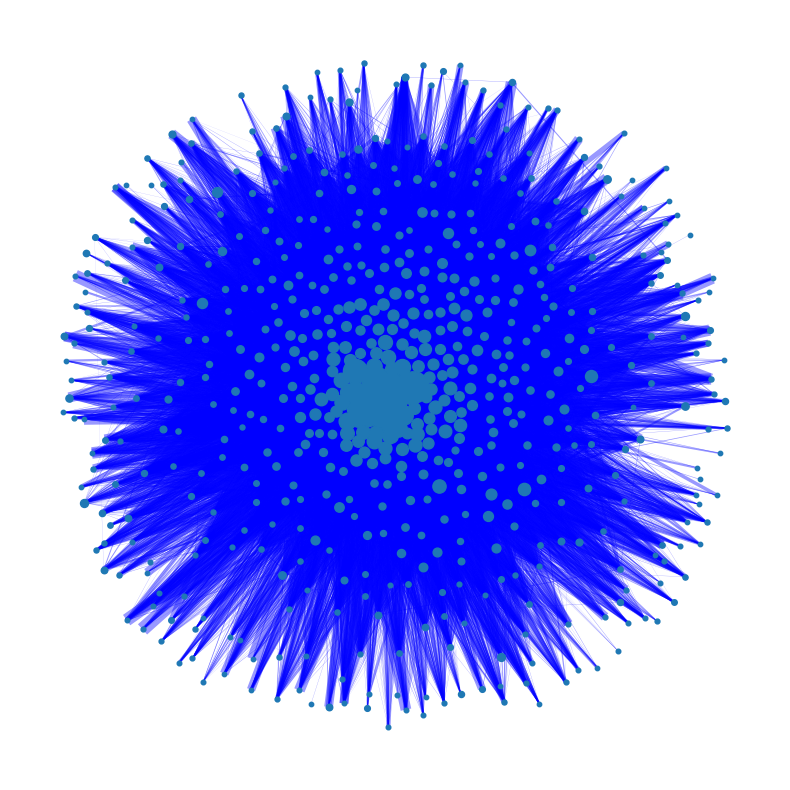

In [52]:
figure(figsize=(8, 8), dpi=100)
# pos = nx.spring_layout(G, k=3.75, scale=None, seed=7, weight='edge_normweights')  # positions for all nodes - seed for reproducibility
# pos = nx.kamada_kawai_layout(G, weight='edge_normweights')
pos = nx.spring_layout(G, k=1.75, weight='weights')


# nodes
for nn in G.nodes():
    # print("nn:", nn)
    nx.draw_networkx_nodes(G, pos, nodelist = [nn],
                           node_size=node_sizes[nn])

# edges
# ecount = 0
# for u,v,w in G.edges(data=True):
#     if ecount%100 == 0:
#         print("{}% done".format(ecount*100/len_edges))

# first we draw normal edges
nx.draw_networkx_edges(G, pos, 
                       edgelist=[e for e in G.edges if weights[e] < 10],
                       width = [w for w in weights.values() if w < 10 ], #baseline_norm_weights],
                       alpha=0.4, edge_color="b")

# then we draw edges with big weights
# nx.draw_networkx_edges(G, pos, 
#                        edgelist=[e for e in G.edges if weights[e] > 10],
#                        width = [2], # default
#                        alpha=0.4, edge_color="#FFA500")
#     ecount += 1

# # labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

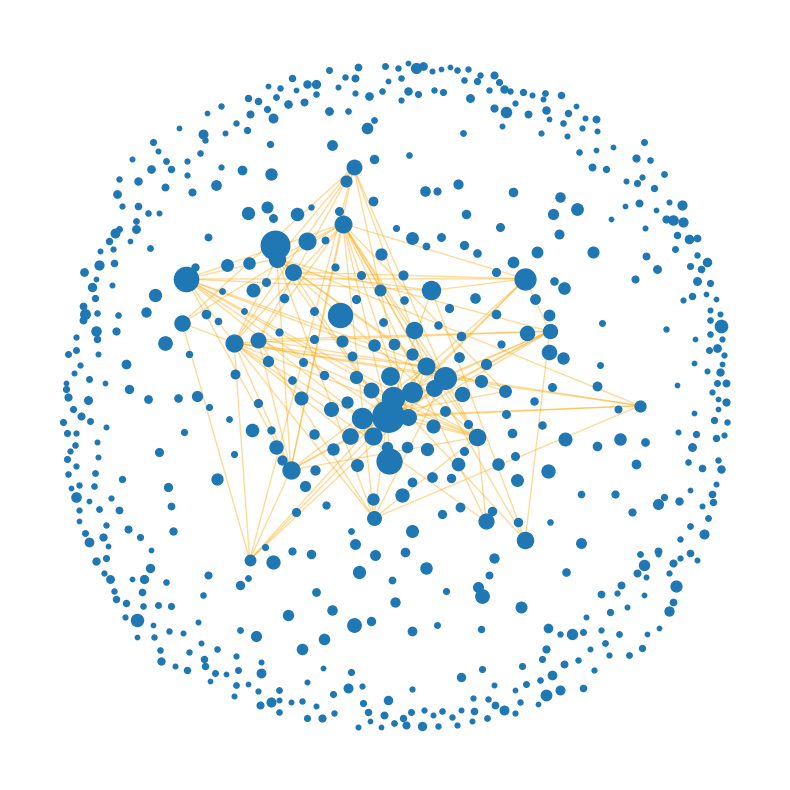

In [59]:
# draw only edges with super strong connections (big weights)
figure(figsize=(8, 8), dpi=100)
# pos = nx.spring_layout(G, k=3.75, scale=None, seed=7, weight='edge_normweights')  # positions for all nodes - seed for reproducibility
# pos = nx.kamada_kawai_layout(G, weight='edge_normweights')
pos = nx.spring_layout(G, k=3, weight='weights')


# nodes
for nn in G.nodes():
    # print("nn:", nn)
    nx.draw_networkx_nodes(G, pos, nodelist = [nn],
                           node_size=node_sizes[nn])

# edges
# ecount = 0
# for u,v,w in G.edges(data=True):
#     if ecount%100 == 0:
#         print("{}% done".format(ecount*100/len_edges))

# first we draw normal edges
# nx.draw_networkx_edges(G, pos, 
#                        edgelist=[e for e in G.edges if weights[e] < 10],
#                        width = [w for w in weights.values() if w < 10 ], #baseline_norm_weights],
#                        alpha=0.4, edge_color="b")

# then we draw edges with big weights
nx.draw_networkx_edges(G, pos, 
                       edgelist=[e for e in G.edges if weights[e] > 10],
                       width = 1, # default
                       alpha=0.4, edge_color="#FFA500")
#     ecount += 1

# # labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [37]:
help(nx.k_core)

Help on function k_core in module networkx.algorithms.core:

k_core(G, k=None, core_number=None)
    Returns the k-core of G.
    
    A k-core is a maximal subgraph that contains nodes of degree k or more.
    
    Parameters
    ----------
    G : NetworkX graph
      A graph or directed graph
    k : int, optional
      The order of the core.  If not specified return the main core.
    core_number : dictionary, optional
      Precomputed core numbers for the graph G.
    
    Returns
    -------
    G : NetworkX graph
      The k-core subgraph
    
    Raises
    ------
    NetworkXError
      The k-core is not defined for graphs with self loops or parallel edges.
    
    Notes
    -----
    The main core is the core with the largest degree.
    
    Not implemented for graphs with parallel edges or self loops.
    
    For directed graphs the node degree is defined to be the
    in-degree + out-degree.
    
    Graph, node, and edge attributes are copied to the subgraph.
    
    

In [52]:
diff = set(main_core.edges()) - set(edge_normweights.keys())
print([d for d in diff if (d[1],d[0]) not in edge_normweights])
# k_core flips edges sometimes!

[]


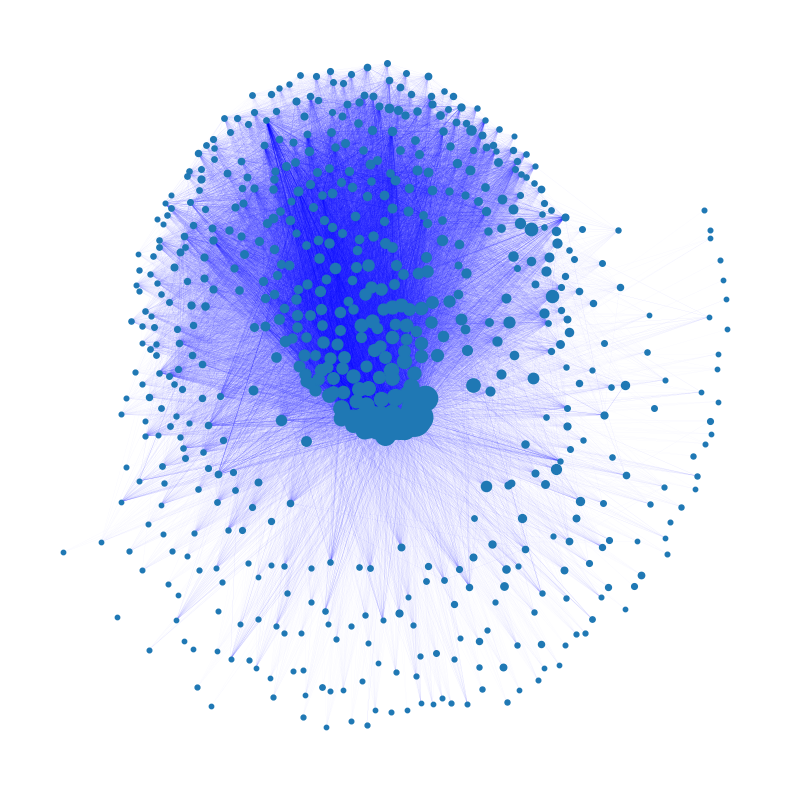

In [55]:
main_core = nx.k_core(G, k=5)
figure(figsize=(8, 8), dpi=100)
# pos = nx.spring_layout(G, k=3.75, scale=None, seed=7, weight='edge_normweights')  # positions for all nodes - seed for reproducibility
pos = nx.kamada_kawai_layout(main_core, weight='edge_normweights')

# nodes
for nn in main_core.nodes():
    # print("nn:", nn)
    nx.draw_networkx_nodes(main_core, pos, nodelist = [nn],
                           node_size=node_sizes[nn])

# edges
# ecount = 0
# for u,v,w in G.edges(data=True):
#     if ecount%100 == 0:
#         print("{}% done".format(ecount*100/len_edges))
nx.draw_networkx_edges(main_core, pos, 
                       edgelist=main_core.edges,
                       width = [edge_normweights[e] if e in edge_normweights else edge_normweights[(e[1],e[0])] for e in main_core.edges()],
                       alpha=0.4, edge_color="b")
#     ecount += 1

# # labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [68]:
degrees = dict(G.degree()).items()
sorted(degrees, key=lambda x:x[1], reverse=True)

[('blogspot.com', 626),
 ('facebook.com', 612),
 ('theguardian.com', 609),
 ('cnn.com', 607),
 ('yahoo.com', 602),
 ('medium.com', 601),
 ('nytimes.com', 600),
 ('bbc.com', 598),
 ('washingtonpost.com', 593),
 ('reuters.com', 586),
 ('apnews.com', 585),
 ('wikipedia.org', 583),
 ('nbcnews.com', 583),
 ('independent.co.uk', 581),
 ('npr.org', 581),
 ('dailymail.co.uk', 580),
 ('msn.com', 579),
 ('nypost.com', 578),
 ('cbc.ca', 576),
 ('cnbc.com', 572),
 ('vice.com', 569),
 ('cbsnews.com', 568),
 ('forbes.com', 565),
 ('usatoday.com', 564),
 ('thehill.com', 563),
 ('foxnews.com', 562),
 ('newsweek.com', 562),
 ('wsj.com', 561),
 ('businessinsider.com', 560),
 ('theverge.com', 560),
 ('wordpress.com', 560),
 ('bloomberg.com', 553),
 ('abc.net.au', 553),
 ('latimes.com', 548),
 ('sky.com', 547),
 ('go.com', 545),
 ('time.com', 536),
 ('wired.com', 535),
 ('theconversation.com', 533),
 ('aljazeera.com', 529),
 ('metro.co.uk', 529),
 ('gizmodo.com', 529),
 ('ctvnews.ca', 523),
 ('arstechnica

In [72]:
G.degree('wsj.com')

561

(array([108.,  63.,  61.,  71.,  80.,  50.,  66.,  62.,  44.,  24.]),
 array([  1. ,  63.5, 126. , 188.5, 251. , 313.5, 376. , 438.5, 501. ,
        563.5, 626. ]),
 <BarContainer object of 10 artists>)

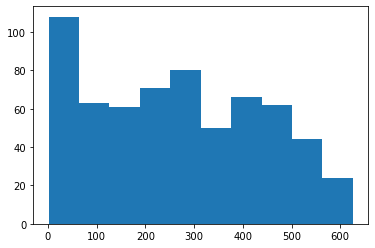

In [62]:
degree_list = list(dict(G.degree()).values())
plt.hist(degree_list)

# Using community detection using greedy modularity based algorithm

In [66]:
from networkx.algorithms.community import greedy_modularity_communities
G_karate = nx.karate_club_graph()
c = list(greedy_modularity_communities(G_karate))
print([len(com) for com in c])

[17, 9, 8]


In [124]:
c = list(greedy_modularity_communities(SG))

In [125]:
len(c)

3

In [128]:
[len(i) for i in c]

[125, 3, 2]

In [130]:
c[2]

frozenset({'eurekalert.org', 'nature.com'})

# Let's color based on clusters

In [36]:
with open('clusters_subscribers.json', 'r') as cluster_infile:
    clusters = json.load(cluster_infile)

In [37]:
for i in range(12):
    print(f"Cluster {i} is of length {len(clusters[str(i)])}")

Cluster 0 is of length 421
Cluster 1 is of length 133
Cluster 2 is of length 156
Cluster 3 is of length 839
Cluster 4 is of length 340
Cluster 5 is of length 44
Cluster 6 is of length 85
Cluster 7 is of length 134
Cluster 8 is of length 233
Cluster 9 is of length 183
Cluster 10 is of length 136
Cluster 11 is of length 81


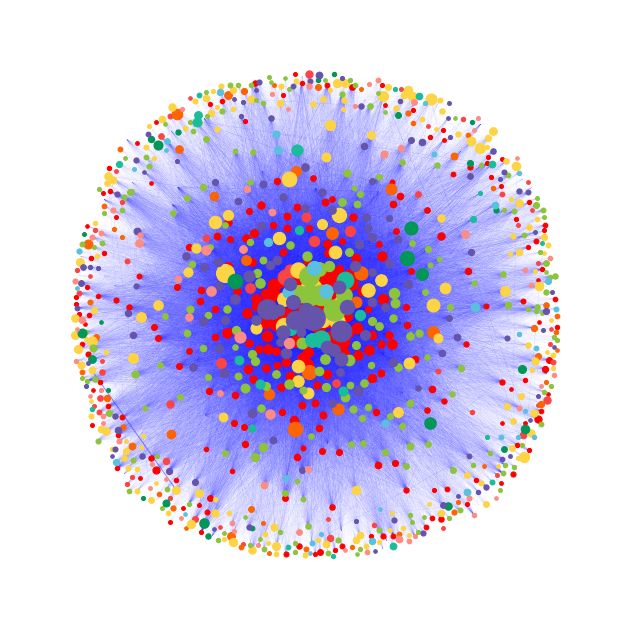

In [38]:
figure(figsize=(8, 8), dpi=80)
pos = nx.spring_layout(G, k=2.5, scale=None, seed=7)  # positions for all nodes - seed for reproducibility

colors = ["#ff0000", "#fc4444", "#fc6404", "#fcd444", "#8cc43c",
         "#029658", "#1abc9c", "#5bc0de", "#6454ac", "#fc8c84"]

# nodes
for i in range(10):
    for nn in clusters[str(i)]:
        if nn in G.nodes():
            nx.draw_networkx_nodes(G, pos, nodelist = [nn],
                               node_size=node_sizes[nn],
                              node_color = colors[i])

# edges
# ecount = 0
# for u,v,w in G.edges(data=True):
#     if ecount%100 == 0:
#         print("{}% done".format(ecount*100/len_edges))
nx.draw_networkx_edges(G, pos, 
                       edgelist=G.edges,
                       width = [w for w in baseline_norm_weights],
                       alpha=0.4, edge_color="b")
#     ecount += 1

# # labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# *Questionable decision here*

In [157]:
# let's take out edges that are of weight <5
weights_filtered = {e:weights[e] for e in weights if weights[e] >= 5 and weights[e] <= 20}

In [158]:
len(weights_filtered)

8547

Then, make new graph.

In [159]:
list(weights_filtered.items())[:5]

[(('bleacherreport.com', 'yahoo.com'), 9.477126295603147),
 (('blogspot.com', 'yahoo.com'), 14.519680236048968),
 (('espn.com', 'yahoo.com'), 18.313413017311625),
 (('latimes.com', 'yahoo.com'), 11.2991086990551),
 (('usatoday.com', 'yahoo.com'), 19.08852088297407)]

In [160]:
SG = nx.Graph()
# for e, w in list(list(weights_filtered.items())[:5]):
for e, w in list(weights_filtered.items()):
    u, v = e
    SG.add_edge(u, v, weight=w)

In [161]:
# check
'nytimes.com' in SG.nodes()

True

In [162]:
len(SG.edges)

8547

In [163]:
len(SG.nodes)

255

Let's freeze the ordering of the edges and their weights

In [184]:
# freeze_edges = list(weights_filtered.keys())
freeze_edges = list(SG.edges())

In [185]:
len(set([tuple(sorted(list(k))) for k in freeze_edges]) - set([tuple(sorted(list(l))) for l in SG.edges()]))

0

In [186]:
# freeze_weights = [weights_filtered[e] for e in freeze_edges]
freeze_weights = list()
for e in list(SG.edges()):
    if e in weights_filtered:
        freeze_weights.append(weights_filtered[e])
    else:
        freeze_weights.append(weights_filtered[(e[1],e[0])])

In [187]:
len(freeze_weights)

8547

Text(0.5, 1.0, 'Edge Weights')

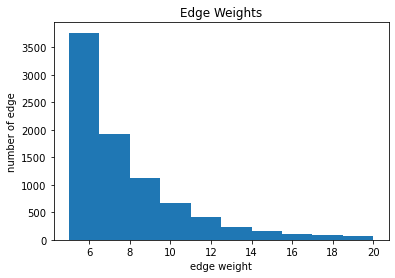

In [188]:
# Edge Weight
plt.close()
# plt.hist([weights[n] for n in G.edges()])
plt.hist([w for w in freeze_weights])
# plt.yscale("log")
plt.ylabel("number of edge")
plt.xlabel("edge weight")
plt.title("Edge Weights")

In [189]:
# norm_weights = normalize(freeze_weights)[0].tolist()
min_max_scaler = preprocessing.MinMaxScaler()
norm_weights = min_max_scaler.fit_transform(np.array([freeze_weights]).T).T[0]

(array([3767., 1927., 1127.,  669.,  415.,  234.,  151.,  113.,   80.,
          64.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

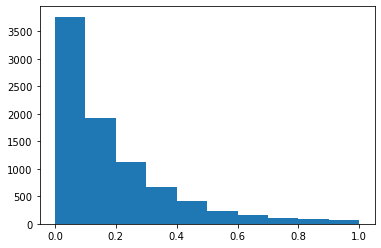

In [190]:
plt.hist(norm_weights)
# plt.yscale("log")

In [191]:
min(norm_weights)

0.0

In [192]:
max(norm_weights)

1.0

Let's multiply the weights by 5 so we get maximum weights of 5

In [193]:
norm_weights = [w*3 for w in norm_weights]

In [194]:
max(norm_weights)

3.0

(array([3767., 1927., 1127.,  669.,  415.,  234.,  151.,  113.,   80.,
          64.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

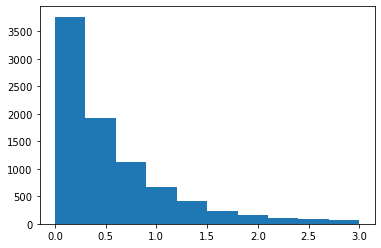

In [195]:
plt.hist(norm_weights)

In [196]:
type(SG.edges)

networkx.classes.reportviews.EdgeView

In [197]:
norm_edge_weights = {freeze_edges[i]:norm_weights[i] for i in range(len(norm_weights))}

In [198]:
ordered_weights = [norm_edge_weights[e] for e in SG.edges]

In [199]:
len(SG.edges())

8547

In [200]:
len(norm_edge_weights.keys())

8547

(array([3767., 1927., 1127.,  669.,  415.,  234.,  151.,  113.,   80.,
          64.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

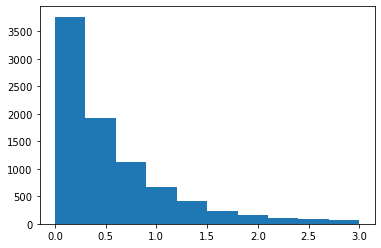

In [201]:
plt.hist(ordered_weights)

# Building a Graph

In [202]:
# ?nx.spring_layout

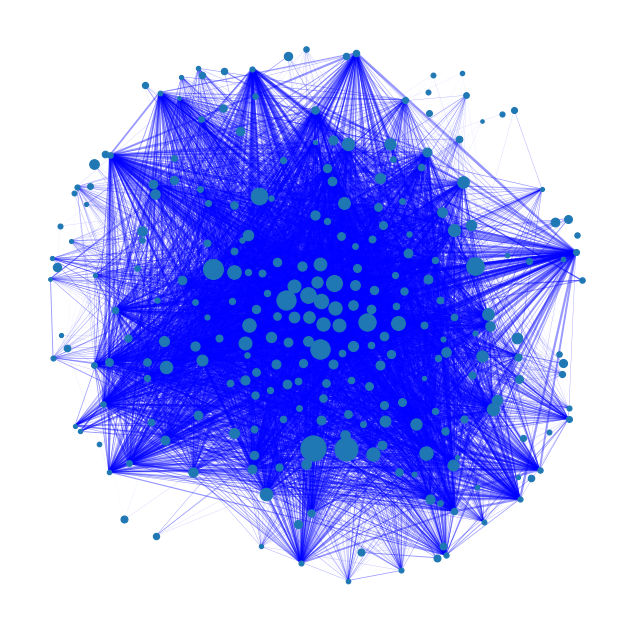

In [203]:
figure(figsize=(8, 8), dpi=80)
pos = nx.spring_layout(G, k=3, scale=None, seed=7, weight='ordered_weights')  # positions for all nodes - seed for reproducibility

# nodes
for nn in SG.nodes():
    # print("nn:", nn)
    nx.draw_networkx_nodes(SG, pos, nodelist = [nn],
                           node_size=node_sizes[nn])

# edges
# ecount = 0
# for u,v,w in G.edges(data=True):
#     if ecount%100 == 0:
#         print("{}% done".format(ecount*100/len_edges))
nx.draw_networkx_edges(SG, pos, 
                       edgelist=SG.edges,
                       width = ordered_weights,
                       alpha=0.4, edge_color="b")
#     ecount += 1

# # labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# Let's color based on clusters

In [66]:
with open('clusters_subscribers.json', 'r') as cluster_infile:
    clusters = json.load(cluster_infile)

In [67]:
for i in range(12):
    print(f"Cluster {i} is of length {len(clusters[str(i)])}")

Cluster 0 is of length 421
Cluster 1 is of length 133
Cluster 2 is of length 156
Cluster 3 is of length 839
Cluster 4 is of length 340
Cluster 5 is of length 44
Cluster 6 is of length 85
Cluster 7 is of length 134
Cluster 8 is of length 233
Cluster 9 is of length 183
Cluster 10 is of length 136
Cluster 11 is of length 81


In [ ]:
?nx.kamada_kawai_layout

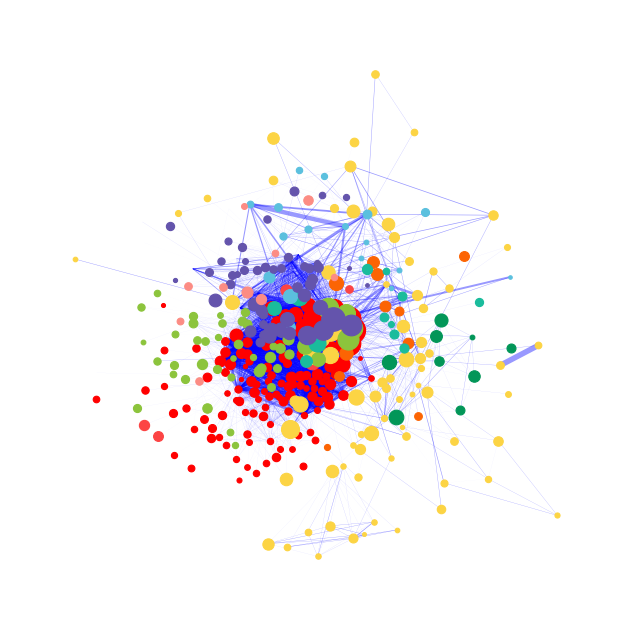

In [100]:
figure(figsize=(8, 8), dpi=80)
# pos = nx.spring_layout(SG, k=3, scale=None, seed=7)  # positions for all nodes - seed for reproducibility
pos = nx.kamada_kawai_layout(SG)

colors = ["#ff0000", "#fc4444", "#fc6404", "#fcd444", "#8cc43c",
         "#029658", "#1abc9c", "#5bc0de", "#6454ac", "#fc8c84"]

# nodes
for i in range(10):
    for nn in clusters[str(i)]:
        if nn in SG.nodes():
            nx.draw_networkx_nodes(SG, pos, nodelist = [nn],
                               node_size=node_sizes[nn],
                              node_color = colors[i])

# edges
# ecount = 0
# for u,v,w in G.edges(data=True):
#     if ecount%100 == 0:
#         print("{}% done".format(ecount*100/len_edges))
nx.draw_networkx_edges(SG, pos, 
                       edgelist=SG.edges,
                       width = ordered_weights,
                       alpha=0.4, edge_color="b")
#     ecount += 1

# # labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# Using community detection using greedy modularity based algorithm

In [104]:
?greedy_modularity_communities

In [204]:
SG_weights = {k:dict(SG.adjacency())[k][l]['weight'] for k in dict(SG.adjacency()) for l in dict(SG.adjacency())[k] }

In [205]:
c = list(greedy_modularity_communities(SG)) #, weight=SG_weights))

In [206]:
[len(community) for community in c]

[253, 2]

In [207]:
for ii in range(1,len(c)):
    print(f"In community {ii}")
    print(c[ii])

In community 1
frozenset({'techxplore.com', 'technologyreview.com'})


# Trying out `plotly`

In [135]:
import plotly.graph_objects as go

In [136]:
SG_edgelist = list(SG.edges())

edge_x = []
edge_y = []


for edge in SG_edgelist:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

In [137]:
link_sizes = [dict(SG.adjacency())[SG_edgelist[i][0]][SG_edgelist[i][1]]['weight'] for i in range(len(SG_edgelist))]

In [138]:
link_sizes[:10]

[14.519680236048968,
 15.200872495960926,
 10.300931076801705,
 20.1376591873138,
 26.573541930220415,
 14.596541597269574,
 11.09192035882174,
 24.627855679417564,
 10.768528425486455,
 16.06059086293233]

In [139]:
SG_edgelist[:10]

[('blogspot.com', 'yahoo.com'),
 ('blogspot.com', 'nytimes.com'),
 ('blogspot.com', 'washingtonpost.com'),
 ('blogspot.com', 'theguardian.com'),
 ('blogspot.com', 'apnews.com'),
 ('blogspot.com', 'cnbc.com'),
 ('blogspot.com', 'independent.co.uk'),
 ('blogspot.com', 'cnn.com'),
 ('blogspot.com', 'thehill.com'),
 ('blogspot.com', 'nbcnews.com')]

In [140]:
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.1, color='#888'),
    # line=dict(width=dict(G.adjacency())[SG_edgelist[i][0]][SG_edgelist[i][1]]['weight'], color='#888'),
    hoverinfo='none',
    mode='lines')

# make multiple traces
# traces={}
# for i in range(len(SG_edgelist)):
#     traces['trace_' + str(i)]=go.Scatter(x = (edge_x[i],), 
#                                            y = (edge_y[i],),
#                                            line=dict(
#                                                 color='#888',
#                                                 width=link_sizes[i]))
# edge_trace=list(traces.values())

In [141]:
node_x = []
node_y = []
for node in SG.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

In [142]:
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [143]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(SG.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(str(adjacencies[0])+'; '+str(len(adjacencies[1]))+' connections')

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [144]:
# ?go.Figure

In [145]:
# edge_trace.append([node_trace])
fig = go.Figure(
             data=[edge_trace, node_trace],
             # data= edge_trace,
             layout=go.Layout(
                title='News Source Network based on Reddit',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    # text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

# Ego Graph

In [83]:
list(G.nodes())[:20]

['chicagotribune.com',
 'espn.com',
 'ktnv.com',
 'cbssports.com',
 '247sports.com',
 'spokesman.com',
 'seattletimes.com',
 'latimes.com',
 'bleacherreport.com',
 'foxsports.com',
 'oregonlive.com',
 'wmcactionnews5.com',
 'tennessean.com',
 'sun-sentinel.com',
 'theathletic.com',
 'montgomeryadvertiser.com',
 'kentuckysportsradio.com',
 'si.com',
 'yahoo.com',
 'wsaz.com']

In [84]:
from networkx.generators import ego_graph

In [121]:
ego = ego_graph(SG, "sputniknews.com")

In [92]:
# dir(nx)

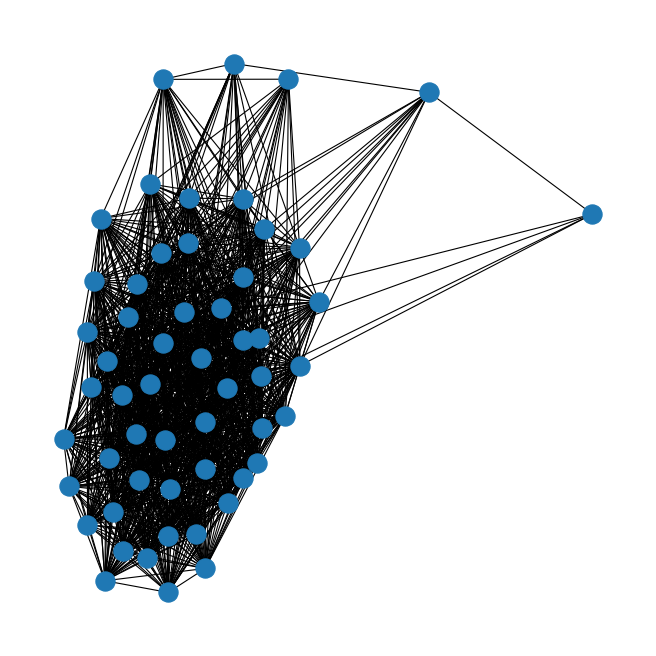

In [122]:
figure(figsize=(8, 8), dpi=80)
nx.draw_spring(ego)

In [120]:
Network Science on YT MOOCs Lada Adamic

SyntaxError: invalid syntax (Temp/ipykernel_14644/1874483544.py, line 1)